# Constants and libraries

In [1]:
'''
In this section one defines environment variables. 
Because I used this notebook on number of machines, I implemented class especially for this. 
You may not needed in one and use just simple definitions.
'''

from system_variables import SystemVariables

# choose system according your current machine
# SYSTEM_NAME = "Windows"
# SYSTEM_NAME = "Colab"
# SYSTEM_NAME = "Kaggle"
SYSTEM_NAME = "Linux"

sv = SystemVariables(SYSTEM_NAME)
PROJECT_FOLDER = sv.get_project_folder()
SRC_FOLDER = sv.get_src_folder()
OUTPUT_FOLDER = sv.get_output_folder()
TUAB_DIRECTORY, TUAB_TRAIN, TUAB_EVAL = sv.get_TUAB_folders()
DEPR_ANON_DIRECTORY = sv.get_depr_anon_folder()
INHOUSE_DIRECTORY = sv.get_inhouse_folder()

print(SYSTEM_NAME)
print()

print(f"{PROJECT_FOLDER = }")
print(f"{SRC_FOLDER = }")
print(f"{OUTPUT_FOLDER = }")
print()

print(f"{TUAB_DIRECTORY = }")
print(f"{TUAB_TRAIN = }")
print(f"{TUAB_EVAL = }")
print()

print(f"{DEPR_ANON_DIRECTORY = }")
print()

print(f"{INHOUSE_DIRECTORY = }")
print()

Linux

PROJECT_FOLDER = ''
SRC_FOLDER = ''
OUTPUT_FOLDER = ''

TUAB_DIRECTORY = 'Data/TUAB/'
TUAB_TRAIN = 'Data/TUAB/train/normal/01_tcp_ar/'
TUAB_EVAL = 'Data/TUAB/eval/normal/01_tcp_ar/'

DEPR_ANON_DIRECTORY = 'Data/depression_anonymized/'

INHOUSE_DIRECTORY = 'Data/inhouse_dataset/EEG_baseline_with_markers_cleaned/preprocessed_data/EEG_baseline/'



In [2]:
import warnings
warnings.simplefilter("ignore")

import os
import sys
import pickle
import json
import random
from IPython.display import display, clear_output
from tqdm.auto import tqdm as tqdm_auto

In [16]:
sys.path.append(SRC_FOLDER)

%load_ext autoreload
%autoreload 1
%aimport utils

from utils import SEED
from utils.data_reading import DataReader
from utils.plotting import dataset_hists
from utils.data_preprocessing import preprocessDepressionAnonymizedData, preprocessInhouseDatasetData, save_preprocessed_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data preview

In [4]:
def tree(data_dir, n_files=2):
    for dir, _, filenames in os.walk(data_dir):
        print(dir)
        for filename in filenames[:n_files]:
            print(os.path.join(dir, filename))

# tree(DEPR_ANON_DIRECTORY)

# tree(INHOUSE_DIRECTORY)

# tree(TUAB_DIRECTORY)
# raw = mne.io.read_raw_edf(TUAB_TRAIN + "/aaaaaaff_s002_t000.edf", preload=False)
# print(raw.ch_names, "\nDuration:", raw.times[-1]/60, "m")
# display(raw.info)
# raw.plot(n_channels=21, duration=100, scalings=100e-6, start=20);#.set_size_inches(5, 5, forward=True)

# Data preprocessing and saving

### TUAB

In [5]:
# def remove_files(dir, tags):
#     for directory, _, file_names in os.walk(TUAB_DIRECTORY):
#         print(directory)
#         for file_name in file_names:
#             if ".csv_chunks_fz_cz_pz_3x124.npy" in file_name or ".csv_targets.npy" in file_name:
#                 os.remove(os.path.join(directory, file_name))

In [6]:
# def readCsv(file_name):
#     file_obj = open(file_name, "r")
#     age = int(file_obj.readline()[8:-1])
#     data = file_obj.readlines()
#     file_obj.close()
#     data[0] = data[0].replace("# ", "")
#     processed_file_name = str(age) + ".csv"
#     processed_file_obj = open(processed_file_name, "w")
#     processed_file_obj.writelines(data)
#     df = pd.read_csv(processed_file_name)
#     processed_file_obj.close()
#     os.remove(processed_file_name)
#     return df, age

# def df2edf(df, sfreq=SAMPLING_FREQUENCY):
#     ch_names = df.columns.to_list()
#     ch_types = ['eeg'] * len(ch_names)
#     info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sfreq)
#     return mne.io.RawArray(df[ch_names].to_numpy(copy=True).T / 1e6, info, verbose=False) #data in microvolts

# def selectChunks(df, ch_names, chunk_duration=124, n_chunks_max=None):
#     chunks = []
#     start_idx = 0
#     end_idx = start_idx + chunk_duration

#     while end_idx <= df.shape[0]:
#         if n_chunks_max != None and len(chunks) >= n_chunks_max:
#             break

#         chunk = df.iloc[start_idx:end_idx]
#         if len(chunk) != chunk_duration:
#             print(f"WARNING: chunk shape = {chunk.shape}")
#             start_idx = end_idx
#             end_idx += chunk_duration
#             continue

#         #std = 5 threshold
#         if chunk[ch_names].to_numpy().std() >= 5:
#             start_idx = end_idx
#             end_idx += chunk_duration
#             continue

#         # std t, t+1 threshold
#         # drop = False
#         # for col in chunk[ch_names]:
#         #     timeseries = chunk[col].to_numpy()
#         #     for i in range(len(timeseries) - 1):
#         #         if np.std([timeseries[i], timeseries[i + 1]]) >= 3:
#         #             drop = True
#         #             break
#         #     if drop:
#         #         break
#         # if drop:
#         #     continue

#         chunks.append(chunk)
#         start_idx = end_idx
#         end_idx += chunk_duration

#     return chunks

# def getAge(file_name):
#     f = open(file_name, "r", encoding="utf-8")
#     try:
#         buffer = "1234"
#         while buffer != "Age:":
#             buffer = buffer[1:] + f.read(1)

#         age = f.read(2)
#         f.close()
#         return int(age)

#     except (UnicodeDecodeError, KeyboardInterrupt, ValueError) as error:
#         f.close()
#         return "error"

# def preprocessRecord(
#         file_name,
#         verbose=False,
#         channels_to_drop=['EEG ROC-REF', 'EEG LOC-REF', 'EEG EKG1-REF', 'PHOTIC-REF', 'IBI', 'BURSTS', 'SUPPR'],
#         sfreq=125,
#         l_freq=L_FREQ,
#         h_freq=H_FREQ,
#         ampl_thresh=AMPLITUDE_THRESHOLD
#     ):
#     #average reference, filtration
#     raw = mne.io.read_raw_edf(file_name, preload=False, verbose=verbose) #data in microvolts
#     raw = raw.drop_channels(channels_to_drop, on_missing="warn")
#     raw = raw.resample(sfreq, npad='auto')
#     raw, _ = mne.set_eeg_reference(raw, ref_channels='average', verbose=verbose) #average reference
#     raw.filter(l_freq=l_freq, h_freq=h_freq, method='iir', verbose=verbose) #filtration
#     df = raw.to_data_frame() #in microvolts
#     ch_names = raw.ch_names

#     #clipping
#     df.loc[:, ch_names].clip(-ampl_thresh, ampl_thresh, inplace=True)

#     #normalization
#     df.loc[:, ch_names] = (df[ch_names] - df[ch_names].mean())/df[ch_names].std()

#     return df, ch_names #time is also among columns

# def processDirectoryData(
#         directory,
#         picked_channels,
#         n_files=None,
#         file_type = "edf",
#         chunks_file_suffix = "_chunks_fz_cz_pz_3x124",
#         targets_file_suffix = "_targets",
#         is_save = True,
#         is_return = True,
#         force_recompute = False,
#         **kwargs):
#     n_files_read = 0
#     n_files_passed = 0

#     if n_files is not None:
#         file_names = os.listdir(directory)[:n_files]
#     else:
#         file_names = os.listdir(directory)

#     if is_return:
#         bunch_of_chunks_list = []
#         bunch_of_targets_list = []

#     for file_name in tqdm_auto(file_names):
#         if fileExtension(file_name) == file_type and \
#             (force_recompute or \
#              not (os.path.exists(directory + fileName(file_name) + chunks_file_suffix + ".npy") and \
#                   os.path.exists(directory + fileName(file_name) + targets_file_suffix + ".npy")\
#                  )\
#             ):
#             chunks_list = []
#             targets_list = []

#             age = getAge(directory + file_name)
#             if age == "error":
#                 n_files_passed += 1
#                 print(f"File {file_name} was passed, passed files: {n_files_passed}, read files: {n_files_read}")
#                 continue
#             n_files_read += 1

#             df, ch_names = preprocessRecord(directory + file_name)
#             chunks_from_record = selectChunks(df, ch_names, **kwargs)
#             for chunk in chunks_from_record:
#                 image = chunk[picked_channels].to_numpy().T
#                 chunks_list.append(image)
#                 targets_list.append(age)

#             chunks = np.array(chunks_list)
#             targets = np.array(targets_list)

#             if is_return:
#                 bunch_of_chunks_list.append(chunks)
#                 bunch_of_targets_list.append(targets)

#             if is_save:
#                 np.save(directory + fileName(file_name) + chunks_file_suffix, chunks)
#                 np.save(directory + fileName(file_name) + targets_file_suffix, targets)

#     print(f"Read files: {n_files_read}, passed files: {n_files_passed}")
#     if is_return:
#         return np.concatenate(bunch_of_chunks_list), np.concatenate(bunch_of_targets_list)


In [7]:
# picked_channels = ['EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF']
# chunks_file_name = "chunks_fz_cz_pz_3x124"
# targets_file_name = "targets"
# for directory in [TUAB_TRAIN, TUAB_EVAL]:
#     chunks, targets = processDirectoryData(
#         directory,
#         picked_channels,
#         n_chunks_max=60,
#         force_recompute=True,
#         chunks_file_suffix="_"+chunks_file_name,
#         targets_file_suffix="_"+targets_file_name
#     )
#     np.save(directory + chunks_file_name, chunks)
#     np.save(directory + targets_file_name, targets)

In [8]:
#concatenate .npy files together
# for directory in [TUAB_TRAIN, TUAB_EVAL]:
#     print(directory)
#     chunks_list = []
#     targets_list = []
#     for file_name in [directory + chunks_file_name + ".npy", directory + targets_file_name + ".npy"]: #delete only files with all chunks
#         if os.path.exists(file_name):
#             os.remove(file_name)

#     for i, file_name in enumerate(tqdm_auto(os.listdir(directory))): #iterate through files from every csv file
#         if chunks_file_name in file_name or targets_file_name in file_name:
#             data = np.load(directory + file_name)
#             if targets_file_name in file_name:
#                 targets_list.append(data)
#             else:
#                 chunks_list.append(data)

#     chunks = np.array(chunks_list).reshape(-1, 1, 3, 124)
#     targets = np.array(targets_list).reshape(-1)
#     print("Chunks:", chunks.shape, "targets:", targets.shape)
#     prefix = "train_" if directory == TUAB_TRAIN else "eval_"
#     np.save(directory + "../" + prefix + chunks_file_name, chunks)
#     np.save(directory + "../" + prefix + targets_file_name, targets)

In [9]:
# from sklearn.model_selection import train_test_split

# chunks_train = np.load(TUAB_TRAIN + "chunks_fz_cz_pz_3x124.npy").reshape(-1, 1, 3, 124)
# targets_train = np.load(TUAB_TRAIN + "targets.npy")
# chunks_val_test = np.load(TUAB_EVAL + "chunks_fz_cz_pz_3x124.npy").reshape(-1, 1, 3, 124)
# targets_val_test = np.load(TUAB_EVAL + "targets.npy")
# chunks_val, chunks_test, targets_val, targets_test = train_test_split(chunks_val_test, targets_val_test, test_size=0.5, random_state=SEED, shuffle=False)
# print(chunks_train.shape, targets_train.shape, chunks_val.shape, targets_val.shape, chunks_test.shape, targets_test.shape)

# save_preprocessed_data(
#     {
#         "chunks_train": chunks_train,
#         "targets_train": targets_train,
#         "chunks_val": chunks_val,
#         "targets_val": targets_val,
#         "chunks_test": chunks_test,
#         "targets_test": targets_test
#     },
#     os.path.join(TUAB_DIRECTORY, "dataset_fz_cz_pz_3x124.pkl")
# )

### Depression anonymized

In [10]:
# epoch_folders = ["epoch_1/", "epoch_3/"]
# picked_channels = ["fz", "cz", "pz"]
# source_freq = 125
# target_freq = 128
# n_samples_per_chunk = target_freq*5

# chunks_list = preprocessDepressionAnonymizedData(
#     DEPR_ANON_DIRECTORY, 
#     epoch_folders, 
#     picked_channels,
#     target_freq = target_freq,
#     n_samples_per_chunk = n_samples_per_chunk
# )
# save_preprocessed_data(chunks_list, DEPR_ANON_DIRECTORY + f"dataset_{target_freq}_{n_samples_per_chunk/target_freq:.1f}.pkl")

### Inhouse dataset

In [11]:
data_folders = ["MDD", "Health"]
picked_channels = ["Fz", "Cz", "Pz"]
source_freq = 500
target_freq = 125
n_samples_per_chunk = target_freq*1

chunks_list = preprocessInhouseDatasetData(
    INHOUSE_DIRECTORY, 
    data_folders, 
    picked_channels,
    source_freq = source_freq,
    target_freq = target_freq,
    n_samples_per_chunk = n_samples_per_chunk
)
save_preprocessed_data(chunks_list, INHOUSE_DIRECTORY + f"dataset_{target_freq}_{n_samples_per_chunk/target_freq:.1f}.pkl")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:31<00:00,  4.78it/s]



Chunks shape: (3, 125) length: 14277


# Data load


In [14]:
# file = DEPR_ANON_DIRECTORY + "dataset_128_10.0.pkl"
# train_set, val_set, test_set = DataReader(file, dataset_type="depression_anonymized").split()

# file = TUAB_DIRECTORY + "dataset_fz_cz_pz_3x124.pkl"
# train_set, val_set, test_set = DataReader(file, dataset_type="TUAB").split()

file = INHOUSE_DIRECTORY + "dataset_125_1.0.pkl"
train_set, val_set, test_set = DataReader(file, dataset_type="inhouse_dataset").split()

chunks_train, chunks_val, chunks_test = train_set["chunk"], val_set["chunk"], test_set["chunk"]
targets_train, targets_val, targets_test = train_set["target"], val_set["target"], test_set["target"]

# Data exploration

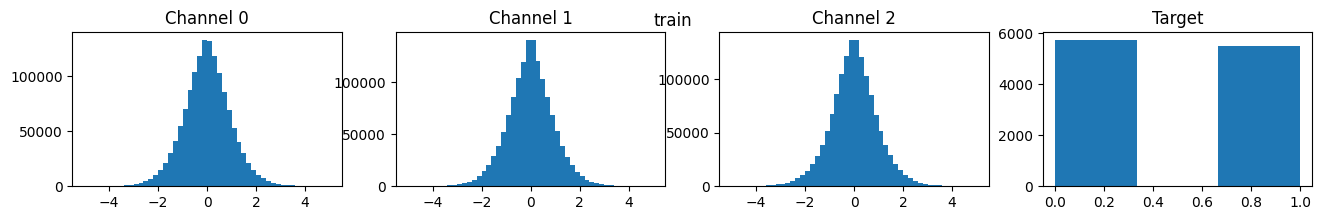

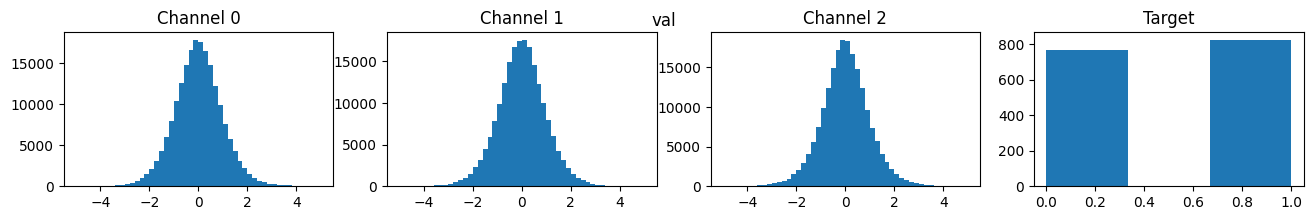

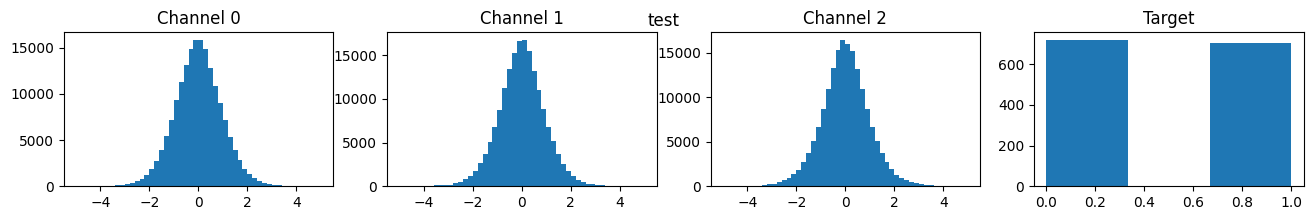

In [17]:
dataset_hists(train_set, val_set, test_set, chunk_bins=50, chunk_range=(-5, 5))
# dataset_hists(train_set, val_set, test_set, chunk_bins=50, chunk_range=(-5, 5), target_bins=10, target_range=(0, 100))